In [1]:
# Robert Bonagura
# Midterm exam

In [ ]:
# 1
install.packages("stringr")

In [135]:
# 2 
pairs = read.csv(url("https://raw.githubusercontent.com/philipperemy/FX-1-Minute-Data/master/pairs.csv"))

In [136]:
# 3
library("stringr")
library("dplyr")

split_cur = function(df){
    name = df[[1]]
    str = str_split(name, "/")
    ccy = str[[1]]
    return(ccy)
}

ccy_pair_names = pairs[1]
split_cur(ccy_pair_names)[1]

[1] "EUR"

In [137]:
# 4
ccy = apply(ccy_pair_names, 1, split_cur)
fc = ccy[1,]
dc = ccy[2,]
fc


[1] "EUR" "EUR" "EUR" "EUR" "EUR" "USD" "USD" "USD" "USD" "GBP" "GBP" "GBP"
[13] "AUD" "AUD" "CHF" "NZD" "NZD" "XAU" "EUR" "AUD" "CAD" "EUR" "GRX" "NZD"
[25] "SGD" "USD" "USD" "USD" "XAU" "AUD" "AUX" "EUR" "EUR" "FRX" "HKX" "NZD"
[37] "SPX" "USD" "USD" "USD" "XAU" "ZAR" "BCO" "ETX" "EUR" "EUR" "GBP" "GBP"
[49] "JPX" "UDX" "USD" "USD" "WTI" "XAU" "AUD" "CAD" "EUR" "EUR" "EUR" "GBP"
[61] "NSX" "UKX" "USD" "USD" "XAG" "XAU"

In [138]:
# 5
pairs$foreign_ccy = fc
pairs$domestic_ccy = dc
head(pairs)

currency_pair_name,currency_pair_code,history_first_trading_month,foreign_ccy,domestic_ccy
EUR/USD,eurusd,200005,EUR,USD
EUR/CHF,eurchf,200203,EUR,CHF
EUR/GBP,eurgbp,200203,EUR,GBP
EUR/JPY,eurjpy,200203,EUR,JPY
EUR/AUD,euraud,200208,EUR,AUD
USD/CAD,usdcad,200006,USD,CAD


In [139]:
# 6
pairs_usd = filter(select(pairs, foreign_ccy, domestic_ccy), domestic_ccy == "USD")
head(pairs_usd)

foreign_ccy,domestic_ccy
EUR,USD
GBP,USD
AUD,USD
NZD,USD
XAU,USD
SPX,USD


In [140]:
#7. Using the "pairs" dataframe, create a new dataframe "domestic_count" 
# which has two columns, "domestic_ccy" and "n", to show the count of pairs for 
# each domestic_ccy.
library(tidyverse)
domestic_count = select(pairs, domestic_ccy)

domestic_count = domestic_count %>% group_by(domestic_ccy) %>% summarize(count=n())
domestic_count = rename(domestic_count, n = count)

head(domestic_count)

domestic_ccy,n
AUD,4
CAD,5
CHF,7
CZK,2
DKK,2
EUR,4


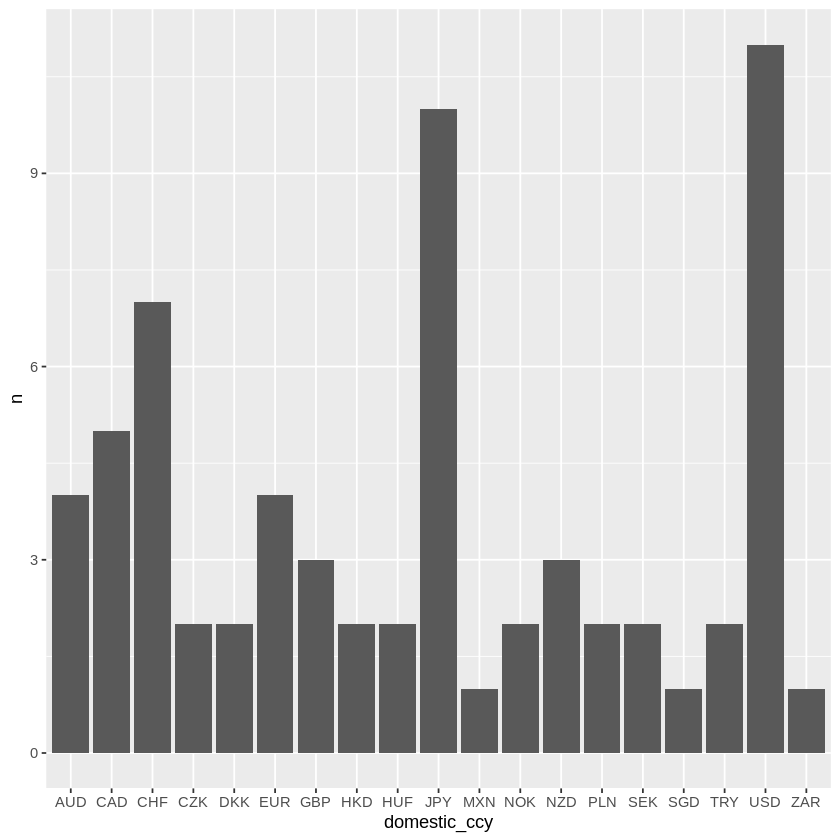

In [141]:
# 8. Plot a barplot for the dataframe "domestic_count". 
# The height of bar is the value of column "n".

ggplot(domestic_count, aes(x=domestic_ccy, y=n)) + geom_bar(stat="identity")

In [142]:
# 9. Using the "pairs" dataframe, create a new dataframe "domestic_count_oldnew" 
# which has three columns, "domestic_ccy", "oldnew", and "n", to show 
# the count of old pairs and new pairs for each domestic_ccy. 
# If "history_first_trading_month" less than 201001, the column "oldnew" is "old", 
# i.e., meaning old pair, if greater than 201001, the column "oldnew" is "new", 
# meaning new pair.

domestic_count_oldnew = select(pairs, domestic_ccy, history_first_trading_month)

domestic_count_oldnew$oldnew = "old"
domestic_count_oldnew$oldnew[domestic_count_oldnew$history_first_trading_month>201001] = "new"

domestic_count_oldnew = select(domestic_count_oldnew, domestic_ccy, oldnew)
domestic_count_oldnew = domestic_count_oldnew %>% group_by(domestic_ccy, oldnew) %>% summarize(count=n())
domestic_count_oldnew = rename(domestic_count_oldnew, n=count)
head(domestic_count_oldnew)


`summarise()` has grouped output by 'domestic_ccy'. You can override using the `.groups` argument.


domestic_ccy,oldnew,n
AUD,new,1
AUD,old,3
CAD,old,5
CHF,old,7
CZK,new,2
DKK,old,2


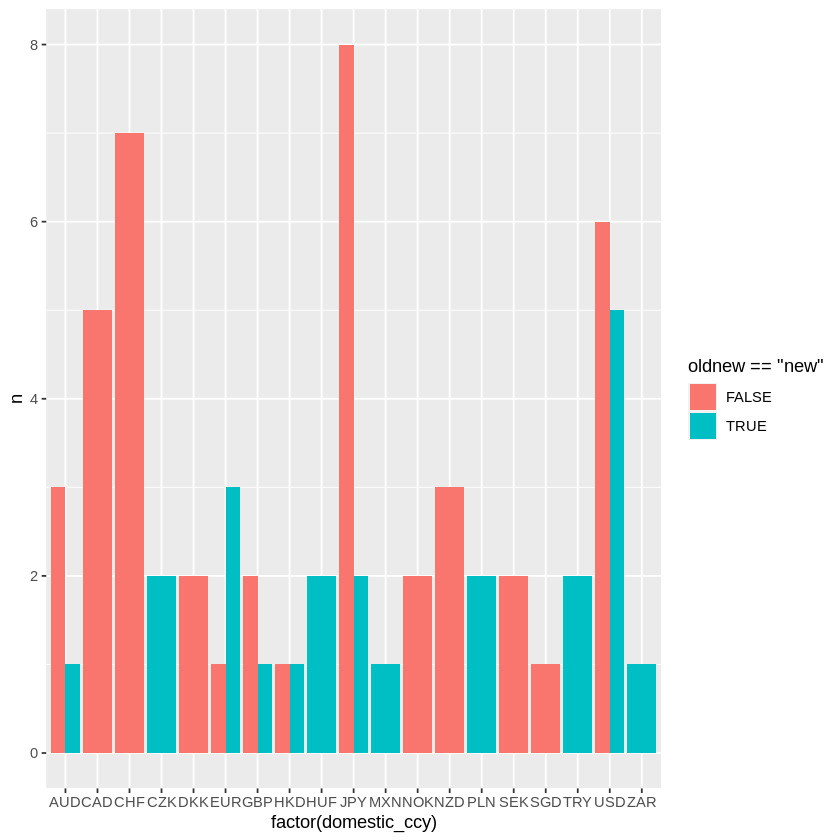

In [143]:
# 10. Plot a grouped barplot for the dataframe "domestic_count_oldnew". 
# The height of bar is the value of column "n" and the color of each bar represents 
# column "oldnew".

ggplot(domestic_count_oldnew, aes(fill=oldnew=="new", y=n, x=factor(domestic_ccy))) +
geom_bar(position="dodge", stat="identity")

In [172]:
# 11. Load the dataset "pairs" into Spark as a distributed 
# dataframe called "pairs_tbl".
library(sparklyr)
library(ggraph)
library(igraph)
library(graphframes)
sc=spark_connect(master="local")
pairs_tbl = copy_to(sc, pairs, "pairs", overwrite = TRUE)
pairs_tbl

Re-using existing Spark connection to local


# Source: spark<pairs> [?? x 5]
   currency_pair_na… currency_pair_c… history_first_tr… foreign_ccy domestic_ccy
   <chr>             <chr>                        <int> <chr>       <chr>       
 1 EUR/USD           eurusd                      200005 EUR         USD         
 2 EUR/CHF           eurchf                      200203 EUR         CHF         
 3 EUR/GBP           eurgbp                      200203 EUR         GBP         
 4 EUR/JPY           eurjpy                      200203 EUR         JPY         
 5 EUR/AUD           euraud                      200208 EUR         AUD         
 6 USD/CAD           usdcad                      200006 USD         CAD         
 7 USD/CHF           usdchf                      200005 USD         CHF         
 8 USD/JPY           usdjpy                      200005 USD         JPY         
 9 USD/MXN           usdmxn                      201011 USD         MXN         
10 GBP/CHF           gbpchf                      200208 GBP         CHF      

In [163]:
# 12. Using "pairs_tbl" on Spark, return a new distributed 
# dataframe "exchangeable" which has two columns "foreign_ccy" 
# and "domestic_ccy" from the original "pairs_tbl" and renames 
# the two columns to "src" and "dst".

exchangeable = pairs_tbl %>% select(foreign_ccy, domestic_ccy)
exchangeable = exchangeable %>% rename(src = foreign_ccy, dst = domestic_ccy)
exchangeable

# Source: spark<?> [?? x 2]
   src   dst  
   <chr> <chr>
 1 EUR   USD  
 2 EUR   CHF  
 3 EUR   GBP  
 4 EUR   JPY  
 5 EUR   AUD  
 6 USD   CAD  
 7 USD   CHF  
 8 USD   JPY  
 9 USD   MXN  
10 GBP   CHF  
# … with more rows

In [164]:
# 13. Write R code with Spark to return a distributed dataframe 
# called "allccy" which has one column "id" and has all unique 
# currencies from the "src" and "dst" columns. 
# The results are the vertices of the currency graph.

from_tbl <- exchangeable %>% 
    distinct(src) %>% 
    transmute(id = src)

to_tbl <- exchangeable %>% 
    distinct(dst) %>% 
    transmute(id = dst)

allccy <- distinct(sdf_bind_rows(from_tbl, to_tbl))
allccy

Warning message:
“ORDER BY is ignored in subqueries without LIMIT
ℹ Do you need to move arrange() later in the pipeline or use window_order() instead?”Warning message:
“ORDER BY is ignored in subqueries without LIMIT
ℹ Do you need to move arrange() later in the pipeline or use window_order() instead?”Warning message:
“ORDER BY is ignored in subqueries without LIMIT
ℹ Do you need to move arrange() later in the pipeline or use window_order() instead?”Warning message:
“ORDER BY is ignored in subqueries without LIMIT
ℹ Do you need to move arrange() later in the pipeline or use window_order() instead?”Warning message:
“ORDER BY is ignored in subqueries without LIMIT
ℹ Do you need to move arrange() later in the pipeline or use window_order() instead?”Warning message:
“ORDER BY is ignored in subqueries without LIMIT
ℹ Do you need to move arrange() later in the pipeline or use window_order() instead?”Warning message:
“ORDER BY is ignored in subqueries without LIMIT
ℹ Do you need to move arrang

# Source: spark<?> [?? x 1]
   id   
   <chr>
 1 BCO  
 2 ETX  
 3 NZD  
 4 XAU  
 5 AUX  
 6 ZAR  
 7 NSX  
 8 SGD  
 9 USD  
10 GBP  
# … with more rows

In [174]:
# 14. Create a simple undirected graph by using "allccy" and 
# "exchangeable", where "exchangeable" has all edges.

edges_tbl <- exchangeable %>% 
    transmute(src = src, dst = dst)

graph = gf_graphframe(allccy, edges_tbl)
graph

# I tried to use the link given in the recent canvs annoucnement
#  but I could not get it to work.
# I hope I am still able to reeceive partial credit for this

# The instructions given by the professor are for Windows and I use Mac and Linux

ERROR: Error: java.lang.ClassNotFoundException: org.graphframes.GraphFrame
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:471)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:589)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:522)
	at java.base/java.lang.Class.forName0(Native Method)
	at java.base/java.lang.Class.forName(Class.java:315)
	at sparklyr.StreamHandler.handleMethodCall(stream.scala:108)
	at sparklyr.StreamHandler.read(stream.scala:62)
	at sparklyr.BackendHandler.$anonfun$channelRead0$1(handler.scala:59)
	at scala.util.control.Breaks.breakable(Breaks.scala:42)
	at sparklyr.BackendHandler.channelRead0(handler.scala:40)
	at sparklyr.BackendHandler.channelRead0(handler.scala:14)
	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:99)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357)
	at io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357)
	at io.netty.handler.codec.ByteToMessageDecoder.fireChannelRead(ByteToMessageDecoder.java:321)
	at io.netty.handler.codec.ByteToMessageDecoder.channelRead(ByteToMessageDecoder.java:295)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357)
	at io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365)
	at io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576)
	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493)
	at io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989)
	at io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74)
	at io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30)
	at java.base/java.lang.Thread.run(Thread.java:829)



In [166]:
# 15. Find which currency is the most exchangeable currency, 
# in terms of the count of direct exchangeable connection to 
# other currencies.

gf_degrees(graph) %>% arrange(desc(degree))


# I hope I am still able to receive partial credit for this
# I could not find graphframe instructions for Linux/Mac

ERROR: Error: object of type 'closure' is not subsettable
